# Tagging genes with ddlite: learning and labeling function iteration

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We'll start to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use distant supervision to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Create a test set
5. Write labeling functions
6. Learn the tagging model
7. Iterate on labeling functions

Parts 3 through 7 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

In [1]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from snorkel.snorkel import *
np.random.seed(seed=1701)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Library/Python/2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/System/Library/Frameworks/Pyth

## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct an `Entities` object with the file.

In [2]:
E = Entities('gene_tag_example/gene_tag_saved_entities_v6.pkl')

## `DDLiteModel` objects and feature generation
We'll then create a `DDLiteModel` object for our extracted gene candidates. This lets us iterate with our model and labeling functions. Since `Entities` object defines a feature generation method, features are automatically created when we initialize a `DDLiteModel` object. These are generic features from the NLP markup and dependency tree in the neighborhood of the mention. Alternatively, you can define a custom feature set as a NumPy array or a Scipy sparse matrix. Here, we pickle our feature matrix so we don't have to recompute it in the future.

In [3]:
feats = None

pkl_f = 'gene_tag_example/gene_tag_feats_v1.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time E.extract_features()
    with open(pkl_f, 'w+') as f:
        cPickle.dump(E.feats, f)

DDL = DDLiteModel(E, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 30533 features for each of 1349 mentions


We need a blind, gold standard ground truth set to evaluate our predictions. We can add these by using the uids for the candidates we want, and align these with a value of 1 for positive or a value of -1 for negative. We'll load in a set now using `DDL.update_gt()` and set it as the holdout. We'll assign half of the holdout to a validation set for parameter tuning, and the other half to a test set.

In [4]:
with open('gene_tag_example/gt/uids.pkl', 'rb') as f:
    uids = cPickle.load(f)
with open('gene_tag_example/gt/gt.pkl', 'rb') as f:
    gt = cPickle.load(f)
    
# Transform for legacy compatibility!
uids = [re.sub(r'\.html', '', re.sub(r'\[\'.*?\'\]', '[\'MATCHER\']', uid)) for uid in uids]    

DDL.update_gt(gt[:50], uids=uids[:50])
DDL.set_holdout(validation_frac=0.5)

## Building a ground truth set with MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using [Mindtagger](http://deepdive.stanford.edu/labeling). This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention of gene, and no otherwise. If you aren't sure, you can abstain from labeling. In a real application, we would likely want to tag more than 20 candidates.

In [5]:
DDL.open_mindtagger(num_sample=100, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


Now, we'll retrieve the tags and add them to our `DDLiteModel`. We can also use a previously defined Mindtagger label set, similar to how we added our gold labels (this time, we'll use indexes instead of uids). These labels are used for evaluating our labeling functions against the *development set*.

In [6]:
DDL.add_mindtagger_tags()

In [7]:
DDL.update_gt(gt[50:], uids=uids[50:])

## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

* The first, second, and third LFs return a positive label if the lemma "gene", "mutant", or "express" appear in a window around the mention, respectively
* The third LF returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise
* The fourth, fifth, and sixth LF return a negative label if the mention candidate contains "DNA", "RNA", or "SNP" respectively (these are common uppercase nouns which are not genes) 

In [8]:
def LF_gene(m):
    return 1 if ('gene' in m.post_window('lemmas')) or ('gene' in m.pre_window('lemmas')) else 0
def LF_gene_dp(m):
    return 1 if 'gene' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_genotype_dp(m):
    return 1 if 'genotype' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_mutant(m):
    return 1 if ('mutant' in m.post_window('lemmas')) or ('mutant' in m.pre_window('lemmas')) else 0
def LF_variant(m):
    return 1 if ('variant' in m.post_window('lemmas')) or ('variant' in m.pre_window('lemmas')) else 0
def LF_express(m):
    return 1 if ('express' in m.post_window('lemmas')) or ('express' in m.pre_window('lemmas')) else 0
def LF_mutation(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ(m):
    return 1 if 'JJ' in m.post_window('poses') else 0
def LF_IN(m):
    return 1 if 'IN' in m.pre_window('poses', 1) else 0

def LF_dna(m):
    return -1 if 'DNA' in m.mention('words') else 0
def LF_rna(m):
    return -1 if 'RNA' in m.mention('words') else 0
def LF_snp(m):
    return -1 if 'SNP' in m.mention('words') else 0
def LF_protein(m):
    return -1 if 'protein' in m.pre_window('lemmas') else 0
def LF_LRB(m):
    return -1 if '-LRB-' in m.post_window('poses', 1) else 0
def LF_RRB(m):
    return -1 if '-RRB-' in m.post_window('poses', 1) else 0
def LF_dev_dp(m):
    return -1 if 'development' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_protein_dp(m):
    return -1 if 'protein' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_network_dp(m):
    return -1 if 'network' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ_dp(m):
    return -1 if 'JJ' in [m.poses[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_NNP(m):
    return -1 if 'NNP' in m.mention('poses') else 0

Our intuition is that the few simple LFs given above won't yield a good model. We'll see this more concretely when we evaluate the labeling functions. For now, let's leave them as is. After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [9]:
LFs = [LF_JJ, LF_JJ_dp, LF_NNP, LF_RRB, LF_dev_dp, LF_dna, LF_express, LF_gene, LF_gene_dp,
       LF_genotype_dp, LF_mutant, LF_mutation, LF_network_dp, LF_protein, LF_protein_dp,
       LF_rna, LF_snp, LF_variant, LF_IN, LF_LRB]
DDL.apply_lfs(LFs, clear=False)

We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:

* Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
* Is there overlap between the LFs? Do many return positive or negative labels for the same candidate?
* Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

In [10]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	69.515%
Overlap:	29.330%
Conflict:	15.396%


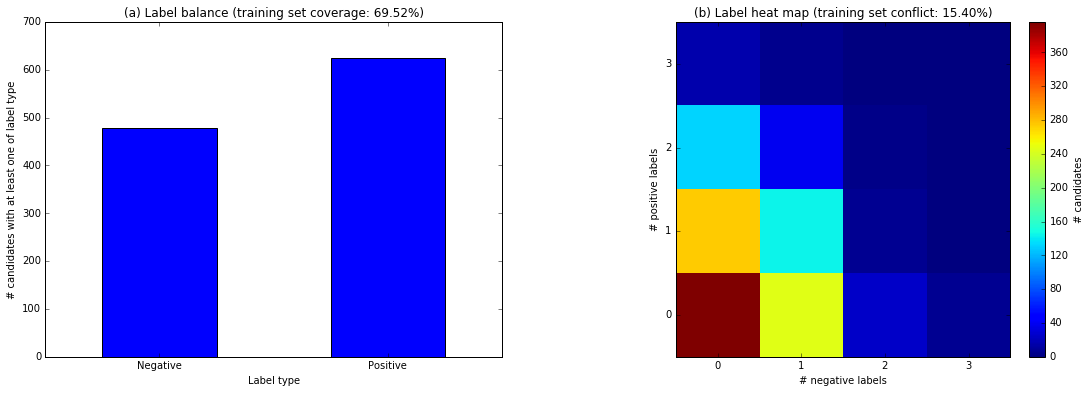

In [11]:
DDL.plot_lf_stats()

As we may expect, the few LFs do not cover the data very well. We can switch to an LF view of these measures and show tables for the LFs with the most conflict, lowest coverage, and lowest empirical accuracy as compared to the development set labels.

In [12]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_JJ,0.15%
LF_dev_dp,0.08%
LF_IN,0.08%


In [13]:
DDL.lowest_coverage_lfs(n=3)

Labeling function,Candidate coverage
LF_network_dp,0.08%
LF_dev_dp,0.15%
LF_express,0.77%


Since our development set is small, we can't evaluate LF performance particularly well. If we observe LFs with very low accuracy, poor generalization, and a sufficiently large sample size, this could be an indication that the LF is buggy.

## Learning
To learn weights for the features and LFs, we use a simple, regularized logistic regression model. Again, the results won't be meaningful without more LFs. We'll tell ddlite to log the results and print out a summary table

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.090644
	Learning epoch = 250	Gradient mag. = 0.094643
Final gradient magnitude for rate=0.01, mu=1e-07: 0.098
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.023619
	Learning epoch = 250	Gradient mag. = 0.024359
	Learning epoch = 500	Gradient mag. = 0.023880
	Learning epoch = 750	Gradient mag. = 0.023425
	Learning epoch = 1000	Gradient mag. = 0.022992
	Learning epoch = 1250	Gradient mag. = 0.022580
	Learning epoch = 1500	Gradient mag. = 0.022187
	Learning epoch = 1750	Gradient mag. = 0.021813
	Learning epoch = 2000	Gradient mag. = 0.021456
	Learning epoch = 2250	Gradient mag. = 0.021115
	Learning epoch = 2500	Gradient mag. = 0.020789
	Learning epoch = 2750	Gradient mag. = 0.020478
Final gradient magnitude for rate=0.01, mu=1e-09: 0.020
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.023619
	Learning epoch = 250	Gradient mag. = 0.024359
	Learning epoch =

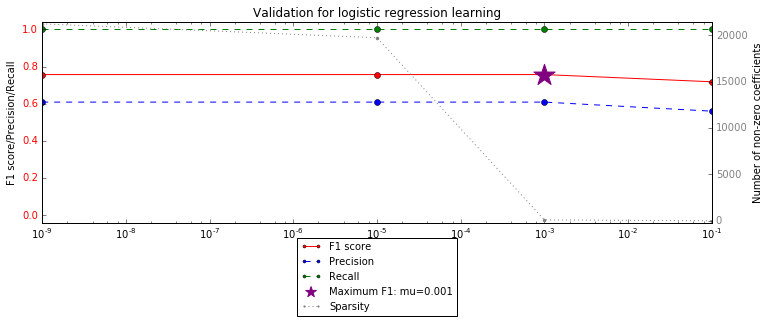

CPU times: user 23.1 s, sys: 262 ms, total: 23.3 s
Wall time: 23.3 s


<snorkel.snorkel.ModelLog instance at 0x114e9d998>

In [14]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions.

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


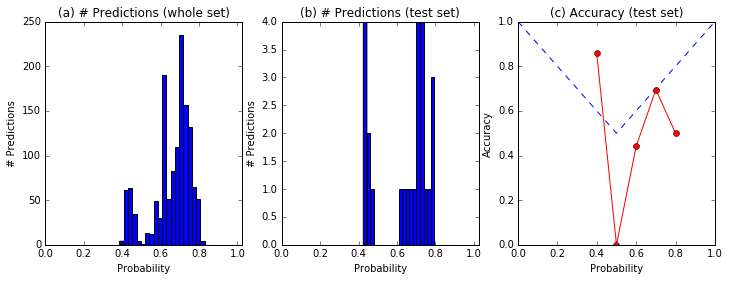

In [15]:
DDL.plot_calibration()

Since we used pipeline learning, we can also see the gain in accuracy we got from using features and not just LFs as a collection of rules.

In [16]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

LF accuracy: 0.700
Full model accuracy: 0.720


## Iterating with labeling functions
After analyzing our LFs and obtaining model results, we can revise our LF set. We can see all of the results thus far, and reopen MindTagger to see some mentions that aren't currently covered by LFs.

In [17]:
DDL.show_log()

ID,# LFs,Test set size,Model,Precision,Recall,F1
0,20,25,Logistic regression,0.778,0.933,0.848


In [18]:
DDL.open_mindtagger(width='100%', height=1200, abstain=True)

Making sure MindTagger is installed. Hang on!


In order to use LSTM to learn weights, we just just call the following functions.

In [19]:
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'n_iter': 300, 'verbose': True, 'contain_mention': True, 'word_window_length': 0, 'ignore_case': False}
%time DDL.train_model(method='lstm', lf_opts=lf_opts, model_opts=model_opts)

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.090644
	Learning epoch = 250	Gradient mag. = 0.094643
Final gradient magnitude for rate=0.01, mu=1e-07: 0.098
Epoch #0, Training error: 0.532717
Epoch #1, Training error: 0.532717
Epoch #2, Training error: 0.532717
Epoch #3, Training error: 0.532717
Epoch #4, Training error: 0.532717
Epoch #5, Training error: 0.532717
Epoch #6, Training error: 0.532717
Epoch #7, Training error: 0.532717
Epoch #8, Training error: 0.532717
Epoch #9, Training error: 0.532717
Epoch #10, Training error: 0.532717
Epoch #11, Training error: 0.532717
Epoch #12, Training error: 0.532717
Epoch #13, Training error: 0.532717
Epoch #14, Training error: 0.532717
Epoch #15, Training error: 0.532717
Epoch #16, Training error: 0.532717
Epoch #17, Training error: 0.532717
Epoch #18, Training error: 0.532717
Epoch #19, Training error: 0.532717
Epoch #20, Training error: 0.532717
Epoch #21, Training error: 0.532717
Epoch #22, Training error: 0.53

In [20]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)

Full model accuracy: 0.680
